### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
#!pip install -U albumentations>=0.3.0
#!pip install albumentations
#!pip install tensorflow 
#!pip install keras 
#!pip install -U --pre segmentation-models --user
#!pip install matplotlib 
#!pip install albumentations==0.0.9 --user

#!pip install opencv-python
#!pip install tensorflow
#!pip install matplotlib 
#!pip install --upgrade albumentations --user
#!pip install segmentation-models
#!pip install torch==2.5.1
#!pip install --upgrade segmentation-models tensorflow keras

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = r'D:\ESCOM\Venas\Forearm Veins (NIR)\data'


In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['veins']
    
    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # Convertir nombres de clases en índices
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        '''
        print(f"Accediendo al índice {i}")
        print(f"Ruta de la imagen: {self.images_fps[i]}")
        print(f"Ruta de la máscara: {self.masks_fps[i]}")
        '''
        
        # Leer imagen
        image = cv2.imread(self.images_fps[i])
        image = np.array(image, dtype=np.uint8)
        # Conversión explícita y verificación
        if not isinstance(image, np.ndarray):
            raise TypeError(f"Image {self.images_fps[i]} could not be read as a NumPy array")
    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (320, 320))

        # Leer máscara
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (320, 320))

        # Verificar que la máscara no sea nula
        if mask is None:
            raise ValueError(f"Máscara no encontrada o inválida: {self.masks_fps[i]}")
        
        '''
        print(f"Original mask shape: {mask.shape}")
        print(f"Unique values in mask: {np.unique(mask)}")
        '''

        # Extraer clases de interés
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float32')
        
        '''
        # Validación después del apilamiento
        print(f"Processed mask shape: {mask.shape}")
        print(f"Unique values after processing: {np.unique(mask)}")
        '''

        # Manejo de fondo si es necesario
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # Aplicar aumentaciones (si existen)
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            

        return image, mask

        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = [self.dataset[j] for j in range(start, stop)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

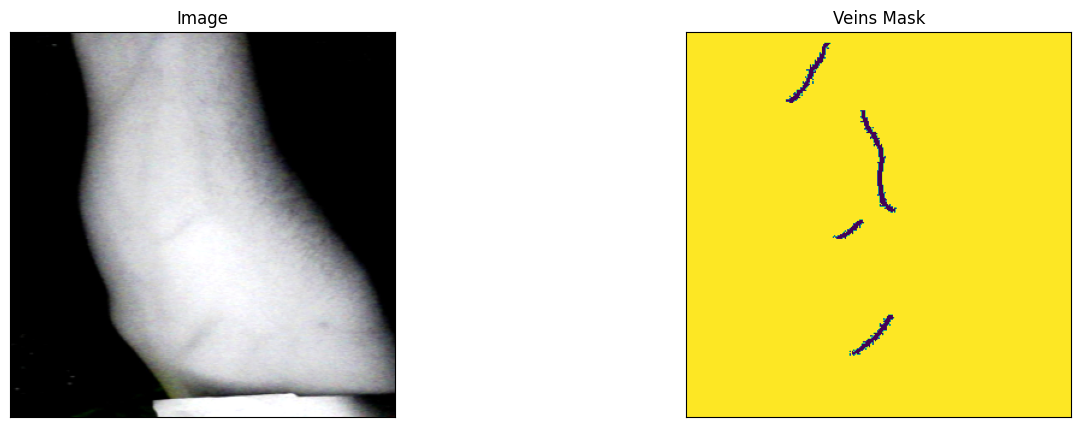

In [8]:
# Crear dataset
dataset = Dataset(x_train_dir, y_train_dir, classes=['veins'])

# Obtener un ejemplo
image, mask = dataset[1]

# Visualizar imagen y máscara
visualize(
    image=denormalize(image),
    veins_mask=mask.squeeze(),  # Eliminar dimensión extra para visualizar
)


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [9]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2

C:\Users\FrankHoshino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# Define heavy augmentations
def get_training_augmentation():
    train_transform = [
        # Flip horizontalmente para cubrir ambas orientaciones
        A.HorizontalFlip(p=0.5),
        
        # Cambios de escala y rotación
        #A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=15, shift_limit=0.05, p=1, border_mode=0),

        # Redimensionar la imagen para garantizar el tamaño uniforme
        #A.PadIfNeeded(min_height=320, min_width=320, p=1),  # Ajusta según tu dataset
        #A.RandomCrop(height=320, width=320, p=1),

        # Mejorar contraste para destacar las venas
        A.OneOf(
            [
                A.CLAHE(p=1),  # Adaptive histogram equalization
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                A.RandomGamma(gamma_limit=(80, 120), p=1),
            ],
            p=0.9,
        ),

        # Filtros para mejorar bordes y texturas
        A.OneOf(
            [
                A.Blur(blur_limit=(3, 7), p=1),  # Difumina suavemente con un kernel aleatorio dentro del rango especificado
                A.MotionBlur(blur_limit=3, p=1),         # Simula movimiento para detectar patrones
                A.GaussNoise(var_limit=(10.0, 50.0), p=1),  # Ruido para robustez
            ],
            p=0.9,
        ),

        # Transformaciones de color dirigidas
        A.OneOf(
            [
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1),
                A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=1),
            ],
            p=0.7,
        ),

        # Reemplazo de transformaciones IAA
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.Perspective(scale=(0.01, 0.05), p=0.5),

        # Normalización para estandarizar la entrada
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), p=1),
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """Ajustar dimensiones para validación."""
    test_transform = [
            # Flip horizontalmente para cubrir ambas orientaciones
            A.HorizontalFlip(p=0.5),
            
            # Cambios de escala y rotación
            #A.ShiftScaleRotate(scale_limit=0.3, rotate_limit=15, shift_limit=0.05, p=1, border_mode=0),

            # Redimensionar la imagen para garantizar el tamaño uniforme
            #A.PadIfNeeded(min_height=320, min_width=320, p=1),  # Ajusta según tu dataset
            #A.RandomCrop(height=320, width=320, p=1),

            # Mejorar contraste para destacar las venas
            A.OneOf(
                [
                    A.CLAHE(p=1),  # Adaptive histogram equalization
                    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                    A.RandomGamma(gamma_limit=(80, 120), p=1),
                ],
                p=0.9,
            ),

            # Filtros para mejorar bordes y texturas
            A.OneOf(
                [
                    A.Blur(blur_limit=(3, 7), p=1),  # Difumina suavemente con un kernel aleatorio dentro del rango especificado
                    A.MotionBlur(blur_limit=3, p=1),         # Simula movimiento para detectar patrones
                    A.GaussNoise(var_limit=(10.0, 50.0), p=1),  # Ruido para robustez
                ],
                p=0.9,
            ),

            # Transformaciones de color dirigidas
            A.OneOf(
                [
                    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1),
                    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=1),
                ],
                p=0.7,
            ),

            # Reemplazo de transformaciones IAA
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.Perspective(scale=(0.01, 0.05), p=0.5),

            # Normalización para estandarizar la entrada
            A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), p=1),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

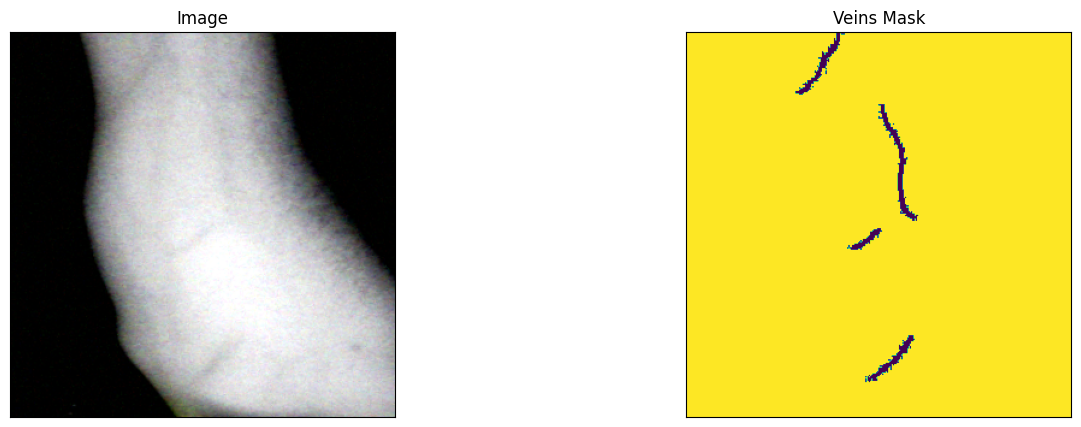

In [11]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['veins'], augmentation=get_training_augmentation())

image, mask = dataset[1] # get some sample
# Transponer la imagen para que sea compatible con Matplotlib

# Visualizar la imagen
visualize(
    image=denormalize(image),  # Asegúrate de convertir el tensor a numpy
    veins_mask=mask.squeeze()  # Eliminar dimensión extra y convertir a numpy
)

# Segmentation model training

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

import segmentation_models as sm

import tensorflow as tf

tf.test.gpu_device_name()

print(tf.config.list_physical_devices('GPU'))

print(tf.test.is_gpu_available())

print(tf.sysconfig.get_build_info())

print(tf.config.list_physical_devices('GPU'))

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `tf.keras` framework.
[]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False
OrderedDict([('is_cuda_build', False), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll')])
[]


In [13]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 2
CLASSES = ['veins']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [14]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
print(n_classes)
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)


1




In [ ]:
# Define Metrics

# Métrica personalizada para IoU
def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

# Métrica personalizada para F1-Score
def f_score(y_true, y_pred, beta=1, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred) - tp
    fn = tf.reduce_sum(y_true) - tp
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + K.epsilon())

def hausdorff_distance_metric(y_true, y_pred):
    """
    Calcula una aproximación del Hausdorff Distance entre dos imágenes binarias.

    Args:
        y_true: Tensor de verdad (ground truth).
        y_pred: Tensor de predicciones.

    Returns:
        Un escalar que representa la distancia Hausdorff promedio.
    """
    # Binarización
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Coordenadas de los puntos donde el valor es 1
    true_points = tf.where(y_true > 0)
    pred_points = tf.where(y_pred > 0)

    # Expandir dimensiones para calcular la distancia
    true_points = tf.expand_dims(true_points, axis=1)
    pred_points = tf.expand_dims(pred_points, axis=0)

    # Calcular distancias punto a punto
    distances = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(true_points - pred_points, tf.float32)), axis=-1))

    # Obtener la distancia máxima mínima (Hausdorff)
    hausdorff_dist = tf.reduce_max(tf.minimum(tf.reduce_min(distances, axis=0), tf.reduce_min(distances, axis=1)))

    return hausdorff_dist

def boundary_iou(y_true, y_pred):
    # Suavizar bordes usando un filtro de Sobel o dilatación
    y_true_edges = tf.image.sobel_edges(y_true)
    y_pred_edges = tf.image.sobel_edges(y_pred)
    # Calcular IoU en los bordes
    return sm.metrics.IOUScore()(y_true_edges, y_pred_edges)

def average_surface_distance(y_true, y_pred):
    """
    Calcula la distancia promedio simétrica de superficie (ASSD) entre dos máscaras binarias.

    Args:
        y_true: Tensor de verdad (ground truth).
        y_pred: Tensor de predicciones.

    Returns:
        Un escalar que representa la distancia promedio simétrica de superficie.
    """
    # Binarización
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Coordenadas de los puntos donde el valor es 1
    true_points = tf.where(y_true > 0)
    pred_points = tf.where(y_pred > 0)

    # Manejar el caso donde no haya puntos
    def safe_min_dist(points, other_points):
        if tf.shape(points)[0] == 0 or tf.shape(other_points)[0] == 0:
            return tf.constant(0.0)
        dists = tf.norm(tf.cast(points, tf.float32)[:, None, :] - tf.cast(other_points, tf.float32)[None, :, :], axis=-1)
        return tf.reduce_mean(tf.reduce_min(dists, axis=1))

    # Calcular distancias promedio en ambas direcciones
    dist_1 = safe_min_dist(true_points, pred_points)
    dist_2 = safe_min_dist(pred_points, true_points)

    return (dist_1 + dist_2) / 2.0

In [15]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

print("Forma de las imágenes en el dataloader:", train_dataloader[0][0].shape)
print("Forma de las máscaras en el dataloader:", train_dataloader[0][1].shape)


image_batch, mask_batch = train_dataloader[0]
print(f"Forma de las imágenes: {image_batch.shape}")  # (BATCH_SIZE, 320, 320, 3)
print(f"Forma de las máscaras: {mask_batch.shape}")  # (BATCH_SIZE, 320, 320, n_classes)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3), f"Forma inesperada: {train_dataloader[0][0].shape}"
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes), f"Forma inesperada: {train_dataloader[0][1].shape}"


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('best_model.weights.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

Forma de las imágenes en el dataloader: (2, 320, 320, 3)
Forma de las máscaras en el dataloader: (2, 320, 320, 1)
Forma de las imágenes: (2, 320, 320, 3)
Forma de las máscaras: (2, 320, 320, 1)


In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

C:\Users\FrankHoshino\AppData\Local\Temp\ipykernel_28016\719100779.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40


17/17 [==============================] - 61s 2s/step - loss: 0.5172 - iou_score: 0.1887 - f1-score: 0.3144 - val_loss: 0.2505 - val_iou_score: 0.9651 - val_f1-score: 0.9822 - lr: 1.0000e-04
Epoch 2/40
17/17 [==============================] - 20s 1s/step - loss: 0.4143 - iou_score: 0.5020 - f1-score: 0.6643 - val_loss: 0.3677 - val_iou_score: 0.7568 - val_f1-score: 0.8614 - lr: 1.0000e-04
Epoch 3/40
17/17 [==============================] - 26s 2s/step - loss: 0.3535 - iou_score: 0.7336 - f1-score: 0.8447 - val_loss: 0.3260 - val_iou_score: 0.9102 - val_f1-score: 0.9529 - lr: 1.0000e-04
Epoch 4/40
17/17 [==============================] - 17s 978ms/step - loss: 0.3074 - iou_score: 0.8743 - f1-score: 0.9326 - val_loss: 0.2972 - val_iou_score: 0.9345 - val_f1-score: 0.9661 - lr: 1.0000e-04
Epoch 5/40
17/17 [==============================] - 44s 3s/step - loss: 0.2755 - iou_score: 0.9241 - f1-score: 0.9605 - val_loss: 0.2903 - val_iou_score: 0.9491 - val_f1-score: 0.9738 - lr: 1

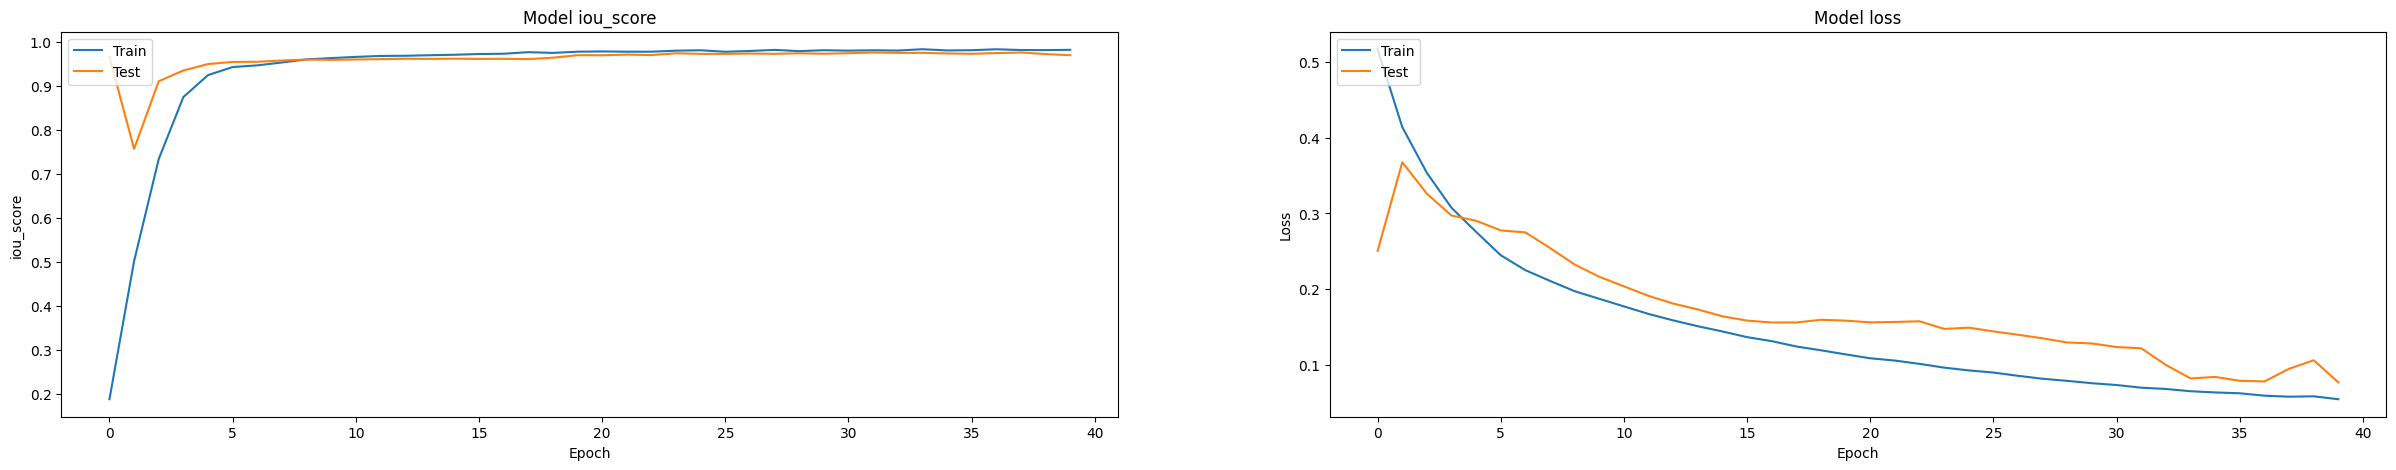

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [16]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [17]:
# load best weights
model.load_weights(r'D:\ESCOM\Venas\transfer_learning\venas\best_model.weights.h5') 

In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

C:\Users\FrankHoshino\AppData\Local\Temp\ipykernel_22612\3518042878.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataloader)


Loss: 0.082242
mean iou_score: 0.96852
mean f1-score: 0.9839


# Visualization of results on test dataset

1/1 [==============================] - 0s 113ms/step


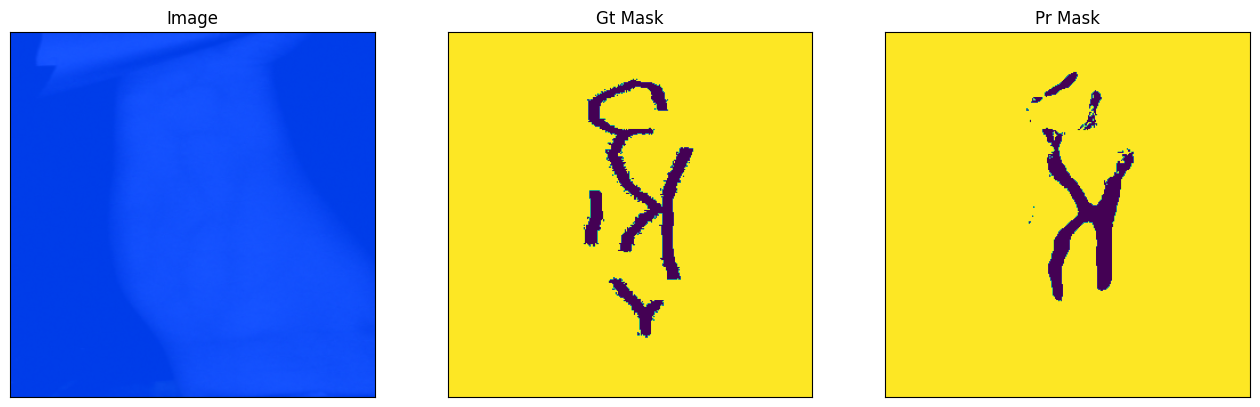

1/1 [==============================] - 0s 118ms/step


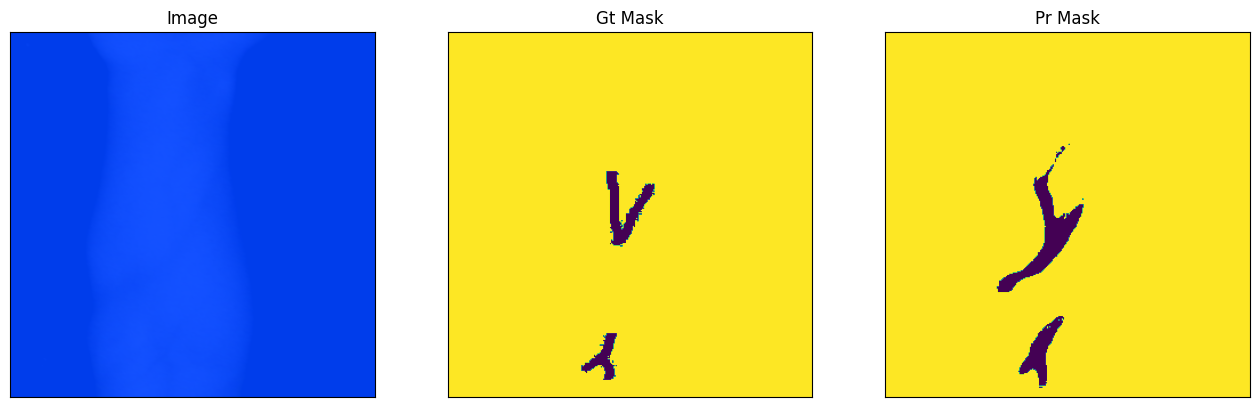

1/1 [==============================] - 0s 117ms/step


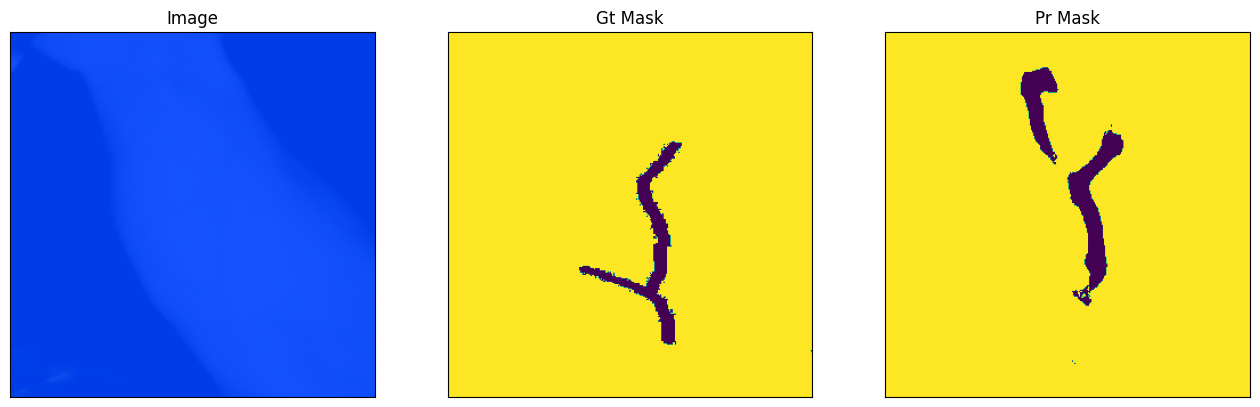

1/1 [==============================] - 0s 120ms/step


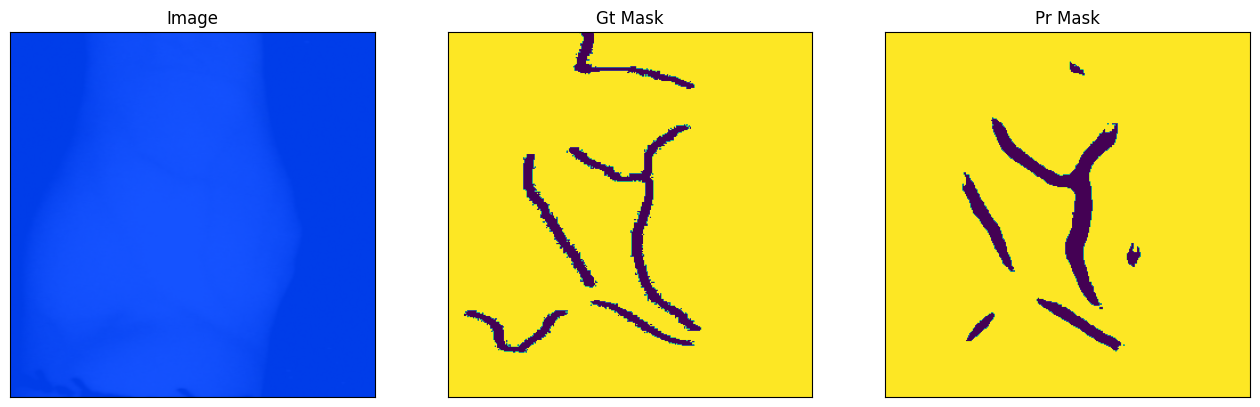

1/1 [==============================] - 0s 121ms/step


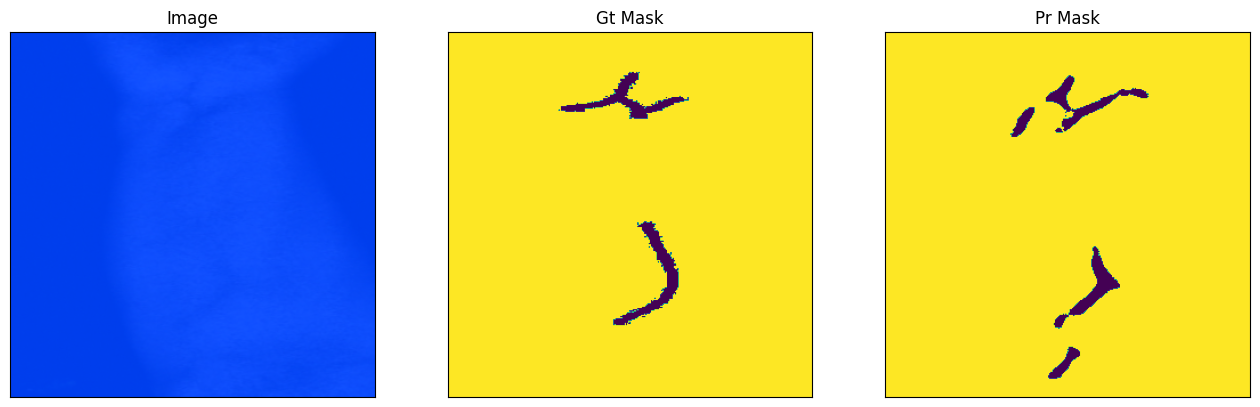

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    # Cargar imagen y máscara real
    image, gt_mask = test_dataset[i]

    # Expandir dimensiones para la predicción
    image = np.expand_dims(image, axis=0)
    #Quitar round para ver el resultado completo
    pr_mask = model.predict(image).round()

    # Eliminar dimensión de batch para visualización
    image = image.squeeze()
    gt_mask = gt_mask.squeeze()
    pr_mask = pr_mask.squeeze()
    

    # Validar formas
    if len(image.shape) != 3:
        raise ValueError(f"La imagen tiene una forma inesperada: {image.shape}")
    if len(gt_mask.shape) != 2:
        raise ValueError(f"La máscara real tiene una forma inesperada: {gt_mask.shape}")
    if len(pr_mask.shape) != 2:
        raise ValueError(f"La máscara predicha tiene una forma inesperada: {pr_mask.shape}")

    # Visualizar
    visualize(
        image=denormalize(image),
        gt_mask=gt_mask,
        pr_mask=pr_mask,
    )